In [81]:
import numpy as np
import matplotlib.pyplot as plt
import random

Text(0.5, 1.0, 'Exact Free energy profile')

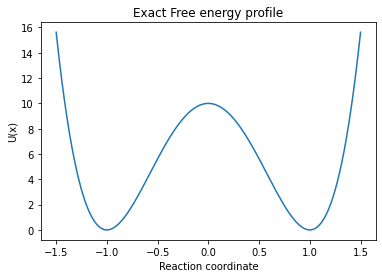

In [82]:
kT = 1.2
MCsteps = 10**2
force_constant = 200
sigma = 0.11 # step size in MCMC

# Model potential
G = 10
U = lambda x: G*(x-1)**2*(x+1)**2

lower_boundary = -1.5
upper_boundary = 1.5

x = np.linspace(lower_boundary,upper_boundary,10**3)
plt.figure()
plt.plot(x,U(x))
plt.xlabel('Reaction coordinate')
plt.ylabel('U(x)')
plt.title('Exact Free energy profile')


In [83]:
num_windows = 14
window_boundaries = np.linspace(lower_boundary, upper_boundary, num = num_windows+1)
X_equilibrium = window_boundaries[:-1] + 0.5*np.mean(np.diff(window_boundaries))

X_record = np.zeros([num_windows, MCsteps])
E_record = np.zeros([num_windows, MCsteps])

X_current = X_equilibrium[0]

In [84]:
def MCMC(kT,
        MCsteps,
        X_equilibrium,
        lower_boundary,
        upper_boundary,
        force_constant,
        U,
        X_current,
        sigma):
    
    beta = 1/kT
    U_biased = lambda x: U(x) + force_constant*(x - X_equilibrium)**2
    E_current = U_biased(X_current)
    
    X_record = np.zeros(MCsteps)
    E_record = np.zeros(MCsteps)
    
    X_record[0] = X_current
    E_record[0] = E_current
    
    for i in range(1,MCsteps,1):
    
        X_new = X_current + sigma*np.random.normal(0,1,1)
    
        if X_new < lower_boundary or X_new > upper_boundary:
        
            X_record[i] = X_current
            E_record[i] = E_current
        
            continue
    
        else:
        
            E_new = U_biased(X_new)
            dE = E_new - E_current
        
            P = np.exp(-beta*dE)
        
            u = random.uniform(0, 1)
        
            if u <= min(1,P):
            
                E_current = E_new
                X_current = X_new
                
            
            X_record[i] = X_current
            E_record[i] = E_current
            
    return [X_record, E_record]
    

In [85]:
count = 0
for i in range(0,num_windows,1):
    
    
    count = count + 1
    print(count)
    
    [ X_record[i,:], E_record[i,:] ] = MCMC(kT,
                                            MCsteps,
                                            X_equilibrium[i],
                                            lower_boundary,
                                            upper_boundary,
                                            force_constant,
                                            U,
                                            X_current,
                                           sigma)
    
    if i < num_windows-1: # Choose a configuration closest to the center of next umbrella
        
        sampled_states_so_far = (np.asanyarray(X_record)).flatten()
        idx = (np.abs(sampled_states_so_far - X_equilibrium[i+1])).argmin()
        X_current = sampled_states_so_far[idx]
        
    else:
        
        continue
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14


Text(0.5, 1.0, 'Biased probability distribution')

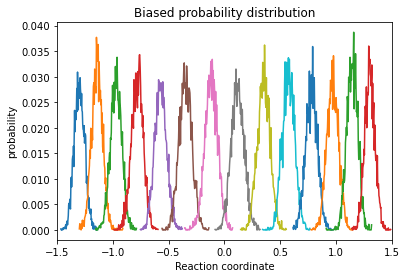

In [86]:
Num_Bins = 100

plt.figure()

for i in range(0,num_windows,1):
    
    values, edges = np.histogram(X_record[i,:], bins= Num_Bins)
    values = values/np.sum(values)
    
    plt.plot(edges[1:], values)
    
plt.xlim([lower_boundary, upper_boundary])
plt.xlabel('Reaction coordinate')
plt.ylabel('probability')
plt.title('Biased probability distribution')

In [98]:
def compute_bias(force_constant, x, X_equilibrium):
    
    bias = force_constant*(x - X_equilibrium)**2
     
     
    return bias

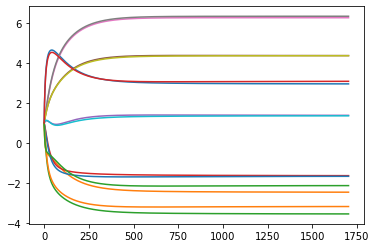

In [99]:
#%% Computing F_i values

beta = 1./kT
diff_threshold = 10**(-5)
diff = 10*diff_threshold

F_record = np.zeros([1, np.size(X_equilibrium,0)])
F = np.ones([1, np.size(X_equilibrium,0)])
F_record[0,:] = F

tt = 0

while diff > diff_threshold:
    
    tt = tt+1
    
    bias = np.zeros([np.size(X_equilibrium,0), MCsteps])
    numerator = np.zeros([np.size(X_equilibrium,0), np.size(X_equilibrium,0), MCsteps])
    denominator = np.zeros([np.size(X_equilibrium,0), MCsteps])
    
    for kk in range(0,np.size(X_equilibrium,0),1):
        
        bias = compute_bias(force_constant, X_record, X_equilibrium[kk])
        numerator[kk,:,:] = np.exp(-beta*bias)
        
        denominator = denominator + MCsteps*np.exp(-beta*bias + beta*F[0][kk])
        
    arg = numerator/denominator
    arg = np.sum(np.sum(arg, axis = 2), axis=1) # sum across configurations and then sum across windows
    
    F = -kT*np.log([arg])
    
    F_record = np.vstack([F_record, F])
    
    diff = np.abs(np.max(F_record[tt,:] - F_record[tt-1,:]))


plt.figure()    
plt.plot(F_record)
    


In [107]:
#%% Compute the un-Biased probability distribution

Num_Bins = 100
EDGES_X = np.linspace(lower_boundary, upper_boundary, num = Num_Bins+1)
beta = 1./kT
prob = np.zeros(Num_Bins)

for i in range(1,np.size(EDGES_X),1):
    
    if i == np.size(EDGES_X):
        
        candidates_pos = np.where(( X_record >= EDGES_X[i-1] ) & ( X_record <= EDGES_X[i] ))
        
    else:
        
        candidates_pos = np.where(( X_record >= EDGES_X[i-1] ) & ( X_record < EDGES_X[i] ))
        
    if not list(candidates_pos[0]):
        
        print('candidates_pos is empty')
        
        prob[i-1] = 0
        
        continue
        
    else:
        
        Sum = 0
        for kk in range(0,np.size(candidates_pos[0]),1):

            denom = 0
            for jj in range(0,np.size(X_equilibrium,0),1):

                bias = compute_bias(force_constant, EDGES_X[i], X_equilibrium[jj])
                denom = denom + MCsteps*np.exp(-beta*bias + beta*F[0][jj])

            Sum = Sum + 1/denom

        prob[i-1] = Sum
            
prob = prob/np.sum(prob)

candidates_pos is empty


<ipython-input-119-bd997b9a28b7>:1: RuntimeWarning: divide by zero encountered in log
  Free_energy = -np.log(prob)-np.min(-np.log(prob))


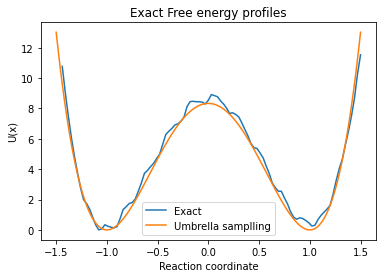

In [119]:
Free_energy = -np.log(prob)-np.min(-np.log(prob))
plt.figure()
plt.plot(EDGES_X[1:], Free_energy)

# Model potential
G = 10
U = lambda x: beta*G*(x-1)**2*(x+1)**2

x = np.linspace(lower_boundary,upper_boundary,10**3)
plt.plot(x,U(x))
plt.xlabel('Reaction coordinate')
plt.ylabel('U(x)')
plt.title('Exact Free energy profiles')

plt.legend(['Exact','Umbrella samplling'])